
<a id='iterative-methods-sparsity'></a>

# Krylov Methods and Matrix Conditioning

## Contents

- [Krylov Methods and Matrix Conditioning](#Krylov-Methods-and-Matrix-Conditioning)  
  - [Overview](#Overview)  
  - [Ill-Conditioned Matrices](#Ill-Conditioned-Matrices)  
  - [Stationary Iterative Algorithms for Linear Systems](#Stationary-Iterative-Algorithms-for-Linear-Systems)  
  - [Krylov Methods](#Krylov-Methods)  
  - [Iterative Methods for Linear-Least Squares](#Iterative-Methods-for-Linear-Least-Squares)  
  - [Iterative Methods for Eigensystems](#Iterative-Methods-for-Eigensystems)  
  - [Krylov Methods for Markov Chain Dynamics](#Krylov-Methods-for-Markov-Chain-Dynamics)  

## Overview

This lecture takes the structure of [numerical methods for linear algebra](numerical_linear_algebra.ipynb) and builds further
towards working with large, sparse matrices.  In the process, we will examine foundational numerical analysis such as
ill-conditioned matrices.

### Setup

In [2]:
using LinearAlgebra, Statistics, BenchmarkTools, Random
Random.seed!(42);  # seed random numbers for reproducibility

### Applications

In this section, we will consider variations on classic problems

1. Solving a linear system for a square $ A $ where we will maintain throughout there is a unique solution to  
  $$
  A x = b
  $$
1. [Linear least-squares](https://en.wikipedia.org/wiki/Linear_least_squares) solution, for a rectangular $ A $  
  $$
  \min_x \| Ax -b \|^2
  $$
  From theory, we know that if $ A $ has linearly independent columns that the solution is the [normal equations](https://en.wikipedia.org/wiki/Linear_least_squares#Derivation_of_the_normal_equations)  
  $$
  x = (A'A)^{-1}A'b
  $$
1. In the case of a square matrix, $ A $ the  eigenvalue problem of finding $ x $ and $ \lambda $ such that  
  $$
  A x = \lambda x
  $$
  For the eigenvalue problems.  Keep in mind that that you do not always require all of the $ \lambda $, and sometimes the largest (or smallest) would be enough.  For example, calculating the spectral radius only requires the maximum eigenvalue in absolute value.  

## Ill-Conditioned Matrices

An important consideration in numerical linear algebra, and iterative methods in general, is the [condition number](https://en.wikipedia.org/wiki/Condition_number#Matrices).

An ill-conditioned matrix is one where the basis of eigenvectors are close to, but not exactly, collinear.  While this poses no problem on pen and paper,
or with infinite precision numerical methods, it is an important in practice for two reasons

1. Ill-conditioned matrices introduce numerical errors roughly in proportion to the base-10 log of the condition number.  
1. The convergence speed of many iterative methods is based on the spectral properties of the matrices (e.g. the basis formed by the eigenvectors), and hence ill-conditioned systems can converge slowly.  


The solutions to these problems are to

- be careful with operations which introduce error based on the condition number (e.g. matrix inversions when the condition number is high)  
- choose, where possible, alternative representations which have less collinearity (e.g. an orthogonal polynomial basis rather than a monomial one)  
- use a preconditioner for iterative methods, which changes the spectral properties to increase convergence speed  

### Condition Number

First, lets define and explore condition number $ \kappa $

$$
\kappa(A) \equiv \|A\| \|A^{-1}\|
$$

where you can use the Cauchy–Schwarz inequality to show that $ \kappa(A) \geq 1 $.  While the condition number can be calculated with any norm, but we will focus on the 2-norm.

First, a warning on calculations: calculating the condition number for a matrix can be an expensive operation (as would calculating a determinant)
and should be thought of as roughly equivalent to doing an eigendecomposition.  So use it for detective work judiciously.

Lets look at the condition number of a few matrices using the `cond` function (which allows a choice of the norm, but we stick with the default 2-norm).

In [3]:
A = I(2)
cond(A)

1.0

Here we see an example of the best-conditioned matrix, the identity matrix with its completely orthonormal basis, is 1.

On the other hand, notice that

In [4]:
ϵ = 1E-6
A = [1.0 0.0
     1.0 ϵ]
cond(A)

2.0000000000005004e6

has a condition number of order `10E6` - and hence (taking the base 10 log) you would expect to be introducing numerical errors of around 6 significant digits if you
are not careful.  For example, note that the inverse has both extremely large and extremely small negative numbers

In [5]:
inv(A)

2×2 Array{Float64,2}:
  1.0    0.0  
 -1.0e6  1.0e6

Since we know that the determinant of nearly collinear matrices is close to zero, this shows another symptom of poor conditioning

In [6]:
det(A)

1.0e-6

However, be careful since the determinant has a scale, while the condition number is dimensionless.  That is

In [7]:
@show det(1000 * A)
@show cond(1000 * A);

det(1000A) = 1.0
cond(1000A) = 2.0000000000005e6


In that case, the determinant of `A` is 1, while the condition number is unchanged.  This example also provides some
intuition that ill-conditioned matrices typically occur when a matrix has radically different scales (e.g. contains both `1` and `1E-6`, or `1000` and `1E-3`).  This can occur frequently with both function approximation and linear-least squares.

### Condition Numbers and Matrix Operations

Multiplying a matrix by a constant does not change the condition number.  What about other operations?

For this example, we see that the inverse has the same condition number (though this will not always be the case).

In [8]:
@show cond(A)
@show cond(inv(A));

cond(A) = 2.0000000000005004e6
cond(inv(A)) = 2.0000000002323308e6


The condition number of the product of two matrices can change radically and lead things to becoming
even more ill-conditioned.

This comes up frequently when calculating the product of a matrix and its transpose (e.g. forming the covariance matrix).  A classic example is the [Läuchli matrix](https://link.springer.com/article/10.1007%2FBF01386022).

In [9]:
lauchli(N, ϵ) = [ones(N)'; ϵ * I(N)]'
ϵ = 1E-8
L = lauchli(3, ϵ) |> Matrix

3×4 Array{Float64,2}:
 1.0  1.0e-8  0.0     0.0   
 1.0  0.0     1.0e-8  0.0   
 1.0  0.0     0.0     1.0e-8

Note that the condition number increases substantially

In [10]:
@show cond(L)
@show cond(L' * L);

cond(L) = 1.732050807568878e8
cond(L' * L) = 2.8104131146758097e32


You can show that the analytic eigenvalues of this are $ \{3 + \epsilon^2, \epsilon^2, \epsilon^2\} $ but the poor conditioning
means it is difficult to distinguish these from $ 0 $.

This comes up when conducting [Principle Component Analysis](https://en.wikipedia.org/wiki/Principal_component_analysis#Singular_value_decomposition), which
requires calculations of the eigenvalues of the covariance matrix

In [11]:
sqrt.(eigen(L*L').values) |> sort

3-element Array{Float64,1}:
 0.0                  
 4.2146848510894035e-8
 1.7320508075688772   

Note that these are significantly different than the known analytic solution and, in particular, are difficult to distinguish from 0.

In [12]:
sqrt.([3 + ϵ^2, ϵ^2, ϵ^2]) |> sort

3-element Array{Float64,1}:
 1.0e-8            
 1.0e-8            
 1.7320508075688772

Alternatively, we could calculate these by taking the square of the singular values of $ L $ itself, which is much more accurate
and lets us clearly distinguish from zero

In [13]:
svd(L).S  |> sort

3-element Array{Float64,1}:
 9.999999999999997e-9
 9.999999999999999e-9
 1.7320508075688774  

Similarly, we are better off calculating least-squares directly rather than forming the normal equation (i.e. $ A' A x = A' b $) ourselves

In [14]:
N = 3
A = lauchli(N, 1E-7)' |> Matrix
b = rand(N+1)
x_sol_1 = A \ b  # using a least-square solver
x_sol_2 = (A' * A) \ (A' * b)  # forming the normal equation ourselves
norm(x_sol_1 - x_sol_2)

2502.053622868482

### Why Monomial Basis are a Bad Idea

A classic example of poorly conditioned matrices is using a monomial basis of a polynomial with interpolation.

Take a grid of points, $ x_0, \ldots x_N $ and values $ y_0, \ldots y_N $ where we want to calculate the
interpolating polynomial.

If we were to use the simplest, and most obvious polynomial basis, then the calculation is to calculate the coefficients $ c_1, \ldots c_n $ where

$$
P(x) = \sum_{i=0}^N c_i x^i
$$

To solve for the coefficients, we notice that this is a simple system of equations

$$
\begin{array}
    \,y_0 = c_0 + c_1 x_0 + \ldots c_N x_0^N\\
    \,\ldots\\
    \,y_N = c_0 + c_1 x_N + \ldots c_N x_N^N
\end{array}
$$

Or, stacking as matrices and vectors $ c = \begin{bmatrix} c_0 & \ldots & c_N\end{bmatrix}, y = \begin{bmatrix} y_0 & \ldots & y_N\end{bmatrix} $ and

$$
A = \begin{bmatrix} 1 & x_0 & x_0^2 & \ldots &x_0^N\\
                    \vdots & \vdots & \vdots & \vdots & \vdots \\
                    1 & x_N & x_N^2 & \ldots & x_N^N
    \end{bmatrix}
$$

We can then calculate the interpolating coefficients as the solution to

$$
A c = y
$$

Implementing this for the interpolation of the $ exp(x) $ function

In [15]:
N = 5
f(x) = exp(x)
x = range(0.0, 10.0, length = N+1)
y = f.(x)  # generate some data to interpolate

A = [x_i^n for x_i in x, n in 0:N]
A_inv = inv(A)
c = A_inv * y
norm(A * c - f.(x), Inf)

1.1932570487260818e-9

The final step just checks the interpolation vs. the analytic function at the nodes.  Keep in mind that this should be very close to zero
since we are interpolating the function precisely at those nodes.
In our example, the Inf-norm (i.e. maximum difference) of the interpolation errors at the nodes is around `1E-9` which
is reasonable for many problems.

But note that with $ N=5 $ the condition number is already of order `1E6`.

In [16]:
cond(A)

564652.3214000977

What if we increase the degree of the polynomial with the hope of increasing the precision of the
interpolation?

In [17]:
N = 10
f(x) = exp(x)
x = range(0.0, 10.0, length = N+1)
y = f.(x)  # generate some data to interpolate

A = [x_i^n for x_i in x, n in 0:N]
A_inv = inv(A)
c = A_inv * y
norm(A * c - f.(x), Inf)

6.227055564522743e-6

Here, we see that hoping to increase the precision between points by adding extra polynomial terms is backfiring.  By going to a 10th order polynomial we have
introduced an error of about `1E-5`, even at the interpolation points themselves.

This blows up quickly

In [18]:
N = 20
f(x) = exp(x)
x = range(0.0, 10.0, length = N+1)
y = f.(x)  # generate some data to interpolate

A = [x_i^n for x_i in x, n in 0:N]
A_inv = inv(A)
c = A_inv * y
norm(A * c - f.(x), Inf)

35556.55954673688

To see the source of the issue, note that the condition number is astronomical.

In [19]:
cond(A)

7.288836972639618e24

At this point, you should be suspicious of the use of `inv(A)` since we have considered solving
linear systems by taking the inverse as verboten.  Indeed, this made things much worse  the
error drop dramatically if we solve it as a linear system

In [20]:
c = A \ y
norm(A * c - f.(x), Inf)

3.4651748137548566e-10

But an error of `1E-10` at the interpolating nodes themselves can be an issue in many applications, and if you increase `N`
then the error will become non-trivial eventually - even without taking the inverse.

The heart of the issue is that the monomial basis leads to a [Vandermonde matrix](https://en.wikipedia.org/wiki/Vandermonde_matrix) which
is especially ill-conditioned.

#### Aside on Runge’s Phenomena

The monomial basis is also a good opportunity to look at a separate type of error due to [Runge’s Phenomena](https://en.wikipedia.org/wiki/Runge%27s_phenomenon).    It is an important
issue in approximation theory, albeit not one driven by numerical approximation errors.

It turns out that using a uniform grid of points is in general the worst possible choice of interpolation nodes for a polynomial approximation.  This phenomena is can be seen with the interpolation of the seemingly innocuous Runge’s function, $ g(x) = \frac{1}{1 + 25 x^2} $.

Lets calculate the interpolation with a monomial basis to find the $ c_i $ such that

$$
\frac{1}{1 + 25 x^2} \approx \sum_{i=0}^N c_i x^i,\, \text{ for } -1 \leq x \leq 1
$$

First, interpolation with $ N = 5 $ and avoid taking the inverse.  In that case, as long as we avoid taking an inverse, the numerical errors from the ill-conditioned matrix are manageable.

┌ Info: Recompiling stale cache file C:\Users\jlperla\.julia\compiled\v1.2\Plots\ld3vC.ji for Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1240


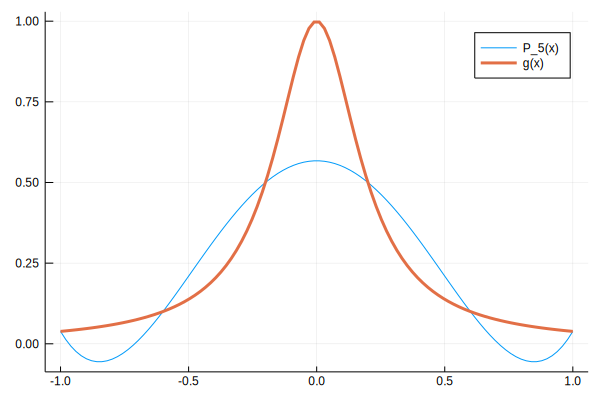

In [21]:
using Plots
N_display = 100
g(x) = 1/(1 + 25x^2)
x_display = range(-1, 1, length = N_display)
y_display = g.(x_display)

# interpolation
N = 5
x = range(-1.0, 1.0, length = N+1)
y = g.(x)
A_5 = [x_i^n for x_i in x, n in 0:N]
c_5 = A_5 \ y

# use the coefficients to evaluate on x_display grid
B_5 = [x_i^n for x_i in x_display, n in 0:N]   # calculate monomials for display grid
y_5 = B_5 * c_5  # calculates for each in x_display_grid
plot(x_display, y_5, label = "P_5(x)")
plot!(x_display, y_display, w = 3, label = "g(x)")

Note, that while the function, $ g(x) $ and the approximation with a 5th order polynomial, $ P_5(x) $ coincide at the 6 nodes, the
approximation has a great deal of error everywhere else.

The oscillations near the boundaries are the hallmarks of Runge’s Phenomena.  You might guess that increasing the number
of grid points and order of the polynomial will lead to better approximations:

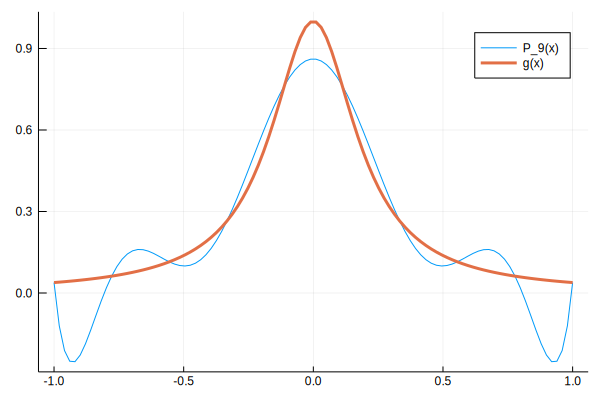

In [22]:
N = 9
x = range(-1.0, 1.0, length = N+1)
y = g.(x)
A_9 = [x_i^n for x_i in x, n in 0:N]
c_9 = A_9 \ y

# use the coefficients to evaluate on x_display grid
B_9 = [x_i^n for x_i in x_display, n in 0:N]   # calculate monomials for display grid
y_9 = B_9 * c_9  # calculates for each in x_display_grid
plot(x_display, y_9, label = "P_9(x)")
plot!(x_display, y_display, w = 3, label = "g(x)")

While the approximation is better near `x=0`, the oscillations near the boundaries have become worse.  Adding on extra polynomial terms will not
globally increase the quality of the approximation.

#### Using an Orthogonal Polynomial Basis

We can minimize the numerical issues of an ill-conditioned basis matrix by choosing a different basis for the polynomials.

For example, [Chebyshev polynomials](https://en.wikipedia.org/wiki/Chebyshev_polynomials) form an orthonormal basis under an appropriate inner product, and we can form precise high-order approximations, with very little numerical error

┌ Info: Recompiling stale cache file C:\Users\jlperla\.julia\compiled\v1.2\ApproxFun\jGqLz.ji for ApproxFun [28f2ccd6-bb30-5033-b560-165f7b14dc2f]
└ @ Base loading.jl:1240


norm(g_approx.(x) - g.(x), Inf) = 4.440892098500626e-16


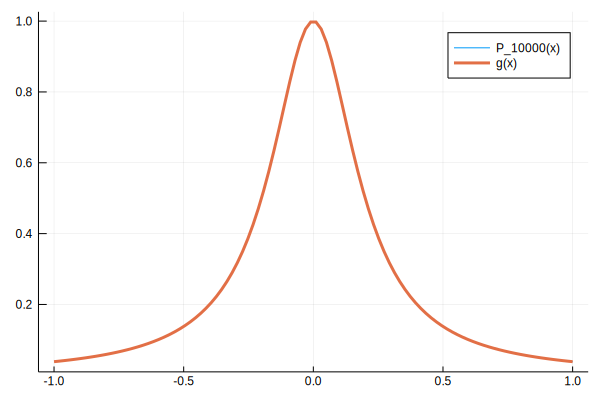

In [23]:
using ApproxFun
N = 10000
S = Chebyshev(-1.0..1.0)  # form chebyshev basis
x = points(S, N)  # chooses chebyshev nodes
y = g.(x)
g_approx = Fun(S,ApproxFun.transform(S,y))  # transform fits the polynomial
@show norm(g_approx.(x) - g.(x), Inf)
plot(x_display, g_approx.(x_display), label = "P_10000(x)")
plot!(x_display, g.(x_display), w = 3, label = "g(x)")

Besides the use of a different polynomial basis, we are approximating at different nodes (i.e. [Chebyshev nodes](https://en.wikipedia.org/wiki/Chebyshev_nodes)).  Interpolation with Chebyshev polynomials at the Chebyshev nodes ends up minimizing (but not eliminating) Runge’s Phenomena.

#### Lessons for Approximation and Interpolation

To summarize

1. Check the condition number on systems you suspect might be ill-conditioned (based on intuition of collinearity).  
1. If you are working with ill-conditioned matrices, be especially careful not to take inverse or multiply by the transpose  
1. Avoid a monomial polynomial basis.  Instead, use polynomials (e.g. Chebyshev or Lagrange) orthogonal under an appropriate inner product, or use a non-global basis such as cubic-splines.  
1. If possible, avoid using a uniform grid for interpolation and approximation and choose nodes appropriate for the basis.  


However, sometimes you can’t avoid ill-conditioned matrices. This is especially common with discretization of PDEs and with linear-least squares.

## Stationary Iterative Algorithms for Linear Systems

As before, consider solving the equation

$$
A x = b
$$

We will now
focus on cases where $ A $ is both massive (e.g. potentially millions of equations), sparse, and sometimes ill-conditioned - but where there is always unique solution.

While this may seem excessive, it occurs in practice due to the curse of dimensionality, discretizations
of PDEs, and when working with big data.

The methods in the previous lectures (e.g. factorization and approaches similar to Gaussian elimination) are called direct methods, and able
in theory to converge to the exact solution in a finite number of steps while directly working with the matrix in memory.

Instead, iterative solutions start with a guess on a solution and iterate until convergence.  The benefit will be that
each iteration uses a lower order operation (e.g. an $ O(N^2) $ matrix-vector product) which will make it possible to

1. solve much larger systems, even if done less precisely.  
1. define linear operators in terms of the matrix-vector products, rather than storing as a matrix.  
1. get approximate solutions in progress prior to the completion of all algorithm steps, unlike the direct methods which only provide a solution at the end.  


Of course, there is no free lunch and the computational order of the iterations themselves would be comparable to the direct methods for a given level of tolerance (e.g. $ O(N^3) $ operations may be required to solve a dense unstructured system).

There are two types of iterative methods we will consider:  first are stationary methods which iterate on a map in a similar way to fixed point problems, and the second are [Krylov](https://en.wikipedia.org/wiki/Krylov_subspace) methods which iteratively solve using left-multiplications of the linear operator.

For our main examples, we will use the valuation of the continuous time markov Chain from the [numerical methods for linear algebra](numerical_linear_algebra.ipynb) lecture.  That is, given a payoff vector $ r $, a
discount rate $ \rho $, and the infinitesimal generator of the markov chain $ Q $, solve the equation

$$
\rho v = r + Q v
$$

With the sizes and types of matrices here, iterative methods are inappropriate in practice, but it will help us understand
the characteristics of convergence, and how they relate to matrix conditioning.

### Stationary Methods

First, we will solve with a direct methods, which will give the solution to machine precision.

In [24]:
using LinearAlgebra, IterativeSolvers, Statistics
α = 0.1
N = 100
Q = Tridiagonal(fill(α, N-1), [-α; fill(-2α, N-2); -α], fill(α, N-1))

r = range(0.0, 10.0, length=N)
ρ = 0.05

A = ρ * I - Q
v_direct = A \ r
mean(v_direct)

100.00000000000004

Without proof, consider given the discount rate of $ \rho > 0 $ this problem could be setup as a contraction for solving the Bellman
equation through methods like value function iteration.

The condition we will examine here is called [**diagonal dominance**](https://en.wikipedia.org/wiki/Diagonally_dominant_matrix).

$$
|A_{ii}| \geq \sum_{j\neq i} |A_{ij}| \quad\text{for all } i = 1\ldots N
$$

That is, for every row, the diagonal is weakly greater in absolute value than the sum of all of the other elements in the row.  In cases
where it is strictly greater, we say that the matrix is strictly diagonally dominant.

With our example, given that $ Q $ is the infinitesimal generator of a markov chain, we know that each row sums to 0, and hence
it is weakly diagonally dominant.

However, notice that when $ \rho > 0 $, since the diagonal of $ Q $ is negative,  $ A = ρ I - Q $ makes the matrix strictly diagonally dominant.

### Jacobi Iteration

For matrices that are **strictly diagonally dominant**, you can prove that a simple decomposition and iteration procedure
will converge.

To solve a system $ A x = b $, split the matrix $ A $ into its diagonal and off-diagonals.  That is,

$$
A = D + R
$$

where

$$
D = \begin{bmatrix} A_{11} & 0 & \ldots & 0\\
                    0    & A_{22} & \ldots & 0\\
                    \vdots & \vdots & \vdots & \vdots\\
                    0 & 0 &  \ldots & A_{NN}
    \end{bmatrix}
$$

and

$$
R = \begin{bmatrix} 0 & A_{12}  & \ldots & A_{1N} \\
                    A_{21}    & 0 & \ldots & A_{2N} \\
                    \vdots & \vdots & \vdots & \vdots\\
                    A_{N1}  & A_{N2}  &  \ldots & 0
    \end{bmatrix}
$$

Rearrange the $ (D + R)x = b $ as

$$
\begin{align}
D x &= b - R x\\
x &= D^{-1} (b - R x)
\end{align}
$$

Where, since $ D $ is diagonal, its inverse is trivial to calculate with $ O(N) $ complexity.

To solve, take an iteration $ x^k $, starting from $ x^0 $, and then form a new guess with

$$
x^{k+1} = D^{-1}(b - R x^k)
$$

The complexity here is a $ O(N^2) $ for the matrix-vector product, and an $ O(N) $ for the vector subtraction and division.

The package [IterativeSolvers.jl](https://github.com/JuliaMath/IterativeSolvers.jl) package implements this method.

For our example, we start if a guess and solve for the value function and iterate

In [25]:
using IterativeSolvers, LinearAlgebra, SparseArrays
v = zeros(N)
jacobi!(v, A, r, maxiter = 40)
@show norm(v - v_direct, Inf)

norm(v - v_direct, Inf) = 0.022858373200932647


0.022858373200932647

With this, after 40 iterations you see the error is in the order of `1E-2`

### Other Stationary Methods

In practice there are many better methods than Jacobi iteration, for example [Gauss-Siedel](https://en.wikipedia.org/wiki/Gauss%E2%80%93Seidel_method). which
splits the matrix $ A = L + U $ into an lower triangular matrix $ L $ and an upper triangular $ U $ without the diagonal.

The iteration becomes

$$
L x^{k+1} = b - U x^k
$$

In that case, since the $ L $ matrix is triangular, the system can be solved in $ O(N^2) $ operations after $ b - U x^k $ is formed

In [26]:
v = zeros(N)
gauss_seidel!(v, A, r, maxiter = 40)
@show norm(v - v_direct, Inf);

norm(v - v_direct, Inf) = 1.5616376089155892e-5


The accuracy increases substantially, after 40 iterations you see the error is in the order of `1E-5`

Another example is [Successive Over-relaxation (SOR)](https://en.wikipedia.org/wiki/Successive_over-relaxation), which takes a relaxation parameter $ \omega > 1 $ and decomposes the matrix as $ A = L + D + U $ with $ L, U $ are strictly upper and lower diagonal matrices, and $ D $ is a diagonal.

Decompose the $ A $ matrix, multiply the system by $ \omega $, and rearrange to find

$$
(D + \omega L) x^{k+1} = \omega b - \left(\omega U +(\omega - 1)D \right)x^k
$$

In that case, $ D + \omega L $ is a triangular matrix, and hence the linear solve is of $ O(N^2) $.

In [27]:
v = zeros(N)
sor!(v, A, r, 1.1, maxiter = 40)
@show norm(v - v_direct, Inf);

norm(v - v_direct, Inf) = 3.745356593753968e-7


The accuracy is now `1E-7`.  If you change the parameter to $ \omega = 1.2 $, the accuracy further increases to `1E-9`.

This technique is a common with iterative methods:  frequently adding a dampening or relaxation parameter will counterintuitively speed up the convergence process.

**Note:** the stationary iterative methods are not always used directly, but are sometimes used as a “smoothing” step (e.g. running 5-10 times) prior to using other Krylov methods.

## Krylov Methods

A more commonly used set of iterative methods are based on [Krylov subspaces](https://en.wikipedia.org/wiki/Krylov_subspace) which involve iterating the $ A^k x $ matrix-vector product, and orthogonalize to ensure the resulting iteration is not too collinear.

The prototypical Krylov method is [Conjugate Gradient](https://en.wikipedia.org/wiki/Conjugate_gradient_method), which requires the $ A $ matrix to be
symmetric and positive definite.

Solving an example

In [28]:
N = 100
A = sprand(100, 100, 0.1)   # 10 percent non-zeros
A = A * A'  # easy way to generate a symmetric positive definite matrix
@show isposdef(A)
b = rand(N)
x_direct = A \ b  # sparse direct solver more appropriate Here
cond(Matrix(A * A'))

isposdef(A) = true


2.519155550817661e13

Notice that the condition numbers tend to be large for big, random matrices.

Solving this system with the conjugate gradient method

In [29]:
x = zeros(N)
sol = cg!(x, A, b, log=true, maxiter = 1000)
sol[end]

Converged after 179 iterations.

### Introduction to Preconditioning

If you tell a numerical analyst you are using direct methods, their first question may be “which factorization?” - but if you tell them you
are using an iterative method, they may ask “which preconditioner?”.

As discussed at the beginning of the lecture, the spectral properties of matrices determine the rate of convergence
of iterative matrices.  In particular, ill-conditioned matrices can converge slowly with iterative methods for the same
reasons that naive value-function iteration will converge slowly if the discount rate is close to `1`.

Preconditioning solves this issue by adjusting the spectral properties of the matrix, at the cost of a some extra computational
operations.

To see an example of a right-preconditioner, consider a matrix $ P $ which has a convenient and numerically stable inverse.  Then,

$$
\begin{align}
A x &= b\\
A P^{-1} P x &= b\\
A P^{-1} y &= b\\
P x &= y
\end{align}
$$

That is, solve $ (A P^{-1})y = b $ for $ y $, and then solve $ P x = y $ for $ x $.

There are all sorts of preconditioners specific to each problem, the key features are that they have convenient (and lower order!) ways to solve the
resulting system and lower the condition number of the matrix.  To see this in action, we can look at a simple preconditioner.

The diagonal precondition is simply `P = Diagonal(A)`.  Depending on the matrix, this can change the condition number a little or a lot.

In [30]:
AP = A * inv(Diagonal(A))
@show cond(Matrix(A))
@show cond(Matrix(AP));

cond(Matrix(A)) = 5.019060346188374e6
cond(Matrix(AP)) = 3.9906483948734603e6


But it may or may not decrease the number of iterations

In [31]:
using Preconditioners
x = zeros(N)
P = DiagonalPreconditioner(A)
sol = cg!(x, A, b, log=true, maxiter = 1000)
sol[end]

Converged after 179 iterations.

Another classic preconditioner is the Incomplete LU decomposition

In [32]:
using IncompleteLU
x = zeros(N)
P = ilu(A, τ = 0.1)
sol = cg!(x, A, b, Pl = P, log=true, maxiter = 1000)
sol[end]

Converged after 97 iterations.

The `τ` parameter determines the degree of the LU decomposition to conduct, providing a tradeoff in preconditioner vs. solve speed.

A good rule of thumb is that you should almost always be using a preconditioner with iterative methods, and you should experiment to find ones appropriate for your problem.

Finally, naively trying another preconditioning approach (called [Algebraic Multigrid](https://en.wikipedia.org/wiki/Multigrid_method#Algebraic_MultiGrid_%28AMG%29)) gives us a further drop in the number of iterations.

In [33]:
x = zeros(N)
P = AMGPreconditioner{RugeStuben}(A)
sol = cg!(x, A, b, Pl = P, log=true, maxiter = 1000)
sol[end]

Converged after 58 iterations.

*Note:* Preconditioning is also available for stationary, iterative methods (see [this example](https://en.wikipedia.org/wiki/Preconditioner#Preconditioned_iterative_methods)), but
is frequently not implemented since they are not often used for the complete solution.

### Methods for General Matrices

There are many algorithms which exploit matrix structure (e.g. the conjugate gradient method for positive definite, and  MINRES for matrices that are only symmetric/hermitian).

On the other hand, if you do not have any structure to your sparse matrix, then GMRES is a good approach.

To experiment with these methods, we will use our ill-conditioned interpolation problem with a monomial basis.

In [34]:
using IterativeSolvers

N = 10
f(x) = exp(x)
x = range(0.0, 10.0, length = N+1)
y = f.(x)  # generate some data to interpolate
A = sparse([x_i^n for x_i in x, n in 0:N])
c = zeros(N+1)  # initial guess required for iterative solutions
results = gmres!(c, A, y, log=true, maxiter = 1000)
println("cond(A) = $(cond(Matrix(A))), $(results[end]) Norm error $(norm(A*c - y, Inf))")

cond(A) = 4.462824600194546e12, Converged after 11 iterations. Norm error 6.507616490125656e-8


That method converged in 11 iterations.  Now try it with an Incomplete LU preconditioner, we see it converges immediately.

In [35]:
N = 10
f(x) = exp(x)
x = range(0.0, 10.0, length = N+1)
y = f.(x)  # generate some data to interpolate
A = [x_i^n for x_i in x, n in 0:N]
P = ilu(sparse(A), τ = 0.1)
c = zeros(N+1)  # initial guess required for iterative solutions
results = gmres!(c, A, y, Pl = P,log=true, maxiter = 1000)
println("$(results[end]) Norm error $(norm(A*c - y, Inf))")

Converged after 1 iterations. Norm error 4.854518920183182e-8


While other preconditioners (e.g. `DiagonalPreconditioner`) may only save an iteration or two.  Keep in mind,
however, to consider the cost of the preconditioning process in your problem.

### Matrix-Free Methods

First, lets use a Krylov method to solve our simple valuation problem

In [36]:
α = 0.1
N = 100
Q = Tridiagonal(fill(α, N-1), [-α; fill(-2α, N-2); -α], fill(α, N-1))

r = range(0.0, 10.0, length=N)
ρ = 0.05

A = ρ * I - Q
v = zeros(N)
results = gmres!(v, A, r, log=true)
v_sol = results[1]
println("$(results[end])")

Converged after 20 iterations.


While the `A` matrix was important to be kept in memory for direct methods, Krylov methods such as GMRES are build on matrix-vector products, i.e. $ A x $ for iterations on the $ x $.

This product can be written directly for a given $ x $,

$$
A x = \begin{bmatrix} (\rho + \alpha) x_1 - \alpha x_2\\
                    - \alpha x_1 + (\rho + 2 \alpha) x_2 - \alpha x_3\\
                    \vdots\\
                    - \alpha x_{N-2} + (\rho + 2 \alpha) x_{N-1} - \alpha x_{N}\\
                    - \alpha x_{N-1} + (\rho + \alpha) x_N
    \end{bmatrix}
$$

This can be implemented as a function (either in-place or out-of-place) which calculates $ y = A x $

In [37]:
A_mul(x) = [ (ρ + α) * x[1] - α * x[2];
             [-α * x[i-1] + (ρ + 2*α) * x[i] - α * x[i+1] for i in 2:N-1];  # comprehension
             - α * x[end-1] + (ρ + α) * x[end]]

x = rand(N)
@show norm(A * x - A_mul(x))  # compare to matrix;

norm(A * x - A_mul(x)) = 0.0


The final line verifies that the `A_mul` function provides the same result as the matrix multiplication with our original `A` for a random vector.

In abstract mathematics, a finite-dimensional [linear operator](https://en.wikipedia.org/wiki/Linear_map) is a mapping $ A : R^N \to R^N $
fulfilling a number of criteria such as $ A (c_1 x_1 + c_2 x_2) = c_1 A x_1 + c_2 A x_2 $ for scalars $ c_i $ and vectors $ x_i $.

Moving from abstract mathematics to [generic programming](../more_julia/generic_programming.ipynb), we can think of a linear operator
as a map fulfilling a number of requirements (e.g. it has a left-multiply to apply the map `*`, an in-place left-multiply `mul!`, an associated `size`, etc.).  A Julia matrix
is just one possible implementation of the abstract concept of a linear operator.

Convenience wrappers can provide some of the boilerplate which turn the `A_mul` function into something which behaves like a matrix.  One
package is [LinearMaps.jl](https://github.com/Jutho/LinearMaps.jl) and another is [LinearOperators.jl](https://github.com/JuliaSmoothOptimizers/LinearOperators.jl)

In [38]:
using LinearMaps
A_map = LinearMap(A_mul, N)  # map uses the A_mul function

LinearMaps.FunctionMap{Float64}(A_mul, 100, 100; ismutating=false, issymmetric=false, ishermitian=false, isposdef=false)

Now, with the `A_map` object, we can fulfill many of the operations we would expect from a matrix

In [39]:
x = rand(N)
@show norm(A_map * x  - A * x)
y = similar(x)
mul!(y, A_map, x) # in-place multiplication
@show norm(y - A * x)
@show size(A_map)
@show norm(Matrix(A_map) - A)
@show nnz(sparse(A_map));

norm(A_map * x - A * x) = 0.0
norm(y - A * x) = 0.0
size(A_map) = (100, 100)
norm(Matrix(A_map) - A) = 0.0
nnz(sparse(A_map)) = 298


**Note:**  In the case of the `sparse(A_map)` and `Matrix(A_map)`, the code is using the left multiplication operator with `N` standard basis vectors to construct
the full matrix.  This should only be used for testing purposes.

But notice that, as the linear operator does not have indexing operations it is not an array or matrix.

In [40]:
typeof(A_map) <: AbstractArray

false

As long as algorithms using linear operators are written generically (e.g. using the matrix-vector `*` or `mul!` functions, etc.) and the types of functions are not
unnecessarily constrained to be `Matrix` or `AbstractArray` when it isn’t strictly necessary, then the `A_map` type can work in places which would otherwise require a matrix.

For example, the Krylov methods in `IterativeSolvers.jl` are written for generic left-multiplication

In [41]:
results = gmres(A_map, r, log = true)  # Krylov method using the matrix-free type
println("$(results[end])")

Converged after 20 iterations.


These methods are typically not competitive with sparse, direct methods unless the problems become very large.  In that case,
you will often want to work with pre-allocated vectors.  Instead of using `y = A * x` for matrix-vector products
you would use in-place `mul!(y, A, x)` function.  The wrappers for linear operators all support in-place non-allocating versions for this purpose.

In [42]:
function A_mul!(y, x)  # inplace version
    y[1] = (ρ + α) * x[1] - α * x[2]
    for i in 2:N-1
        y[i] = -α * x[i-1] + (ρ + 2α) * x[i] -α * x[i+1]
    end
    y[end] = - α * x[end-1] + (ρ + α) * x[end]
    return y
end
A_map_2 = LinearMap(A_mul!, N, ismutating = true)  # ismutating == in-place

v = zeros(N)
@show norm(A_map_2 * v - A * v)  # can still call with * and have it allocate
results = gmres!(v, A_map_2, r, log=true)  # in-place gmres
println("$(results[end])")

norm(A_map_2 * v - A * v) = 0.0
Converged after 20 iterations.


Finally, keep in mind that the linear operators can compose, so that $ A (c_1 x) + B (c_2 x) + x  = (c_1 A + c_2 B + I) x $ is well-defined for any linear operators - just as
it would be for matrices $ A, B $ and scalars $ c_1, c_2 $.

For example, take $ 2 A x + x = (2 A + I) x \equiv B x $ as a new linear map,

In [43]:
B = 2.0 * A_map  + I  # composite linear operator
B * rand(N)  # left-multiply works with the composition
typeof(B)

LinearMaps.LinearCombination{Float64,Tuple{LinearMaps.CompositeMap{Float64,Tuple{LinearMaps.FunctionMap{Float64,typeof(A_mul),Nothing},LinearMaps.UniformScalingMap{Float64}}},LinearMaps.UniformScalingMap{Bool}}}

The wrappers, such as `LinearMap` wrappers make this composition possible by keeping of the composition
graph of the expression (i.e. `LinearCombination`), and implementing the left-multiply recursively using the rules of linearity.

Another example is to solve the $ \rho v = r + Q v $ equation for $ v $ with composition of matrix-free methods for $ L $
rather than as creating the full $ A = \rho - Q $ operator, which we implemented as `A_mul`

In [44]:
Q_mul(x) = [ -α * x[1] +     α * x[2];
            [α * x[i-1] - 2*α * x[i] + α*x[i+1] for i in 2:N-1];  # comprehension
            α * x[end-1] - α * x[end];]
Q_map = LinearMap(Q_mul, N)
A_composed = ρ * I - Q_map   # map composition, performs no calculations
@show norm(A - sparse(A_composed))  # test produces the same matrix
gmres(A_composed, r, log=true)[2]

norm(A - sparse(A_composed)) = 0.0


Converged after 20 iterations.

In this example, the left-multiply of the `A_composed` used by `gmres` uses the left-multiply of `Q_map` and `I` with the rules
of linearity.  The `A_composed = ρ * I - Q_map` operation simply creates the `LinearMaps.LinearCombination` type, and doesn’t perform any calculations on its own.

## Iterative Methods for Linear-Least Squares

In theory, the solution to the least-squares problem, $ \min_x \| Ax -b \|^2 $ is simply the solution to the normal equations $ (A'A) x  = A'b $.

We saw, however, that in practice direct methods use a QR decomposition - in part because ill-conditioned $ A $ become even worse when $ A' A $ is formed.

For large problems, we can also consider Krylov methods for solving the linear-least squares problem.  One formulation is the [LSMR](https://stanford.edu/group/SOL/software/lsmr/LSMR-SISC-2011.pdf) algorithm
which can solve the regularized

$$
\min_x \| Ax -b \|^2 + \| \lambda x\|^2
$$

The purpose of the $ \lambda \geq 0 $ parameter is to dampen the iteration process and/or regularize the solution.  This isn’t required, but can help convergence for ill-conditioned $ A $ matrices.  With the
dampening parameter, the normalized equations would become $ (A'A + \lambda^2 I) x  = A'b $.

We can compare solving the least-squares problem with LSMR and direct methods

In [45]:
M = 1000
N = 10000
σ = 0.1
β = rand(M)
# simulate data
X = sprand(N, M, 0.1)
y = X * β + σ * randn(N)
β_direct = X \ y
results = lsmr(X, y, log = true)
β_lsmr = results[1]
@show norm(β_direct - β_lsmr)
println("$(results[end])")

norm(β_direct - β_lsmr) = 3.4110302264513887e-6
Converged after 16 iterations.


Note that rather than forming this version of the normal equations, the LSMR algorithm uses the $ A x $ and $ A' y $ (i.e. the matrix-vector product, and the matrix-transpose vector product) to implement an iterative
solution.  Unlike the previous versions, the left-multiplies is insufficient since the least squares also deals with the transpose of the operators.  For this reason, to use
matrix-free methods you need to define the `A * x` and `transpose(A) * y` functions separately.

In [46]:
# Could implement as matrix-free functions.
X_func(u) = X * u  # matrix-vector product
X_T_func(v) = X' * v  # i.e. adjoint-vector product

X_map = LinearMap(X_func, X_T_func, N, M)
results = lsmr(X_map, y, log = true)
println("$(results[end])")

Converged after 16 iterations.


## Iterative Methods for Eigensystems

When you use `eigen` on a dense matrix, it calculates an eigendecomposition and provides all of the eigenvalues and eigenvectors.

While sometimes this is necessary, a spectral decomposition of a dense, unstructured matrix is one of the costliest $ O(N^3) $ operations (i.e., it has
one of the largest constants).  For large matrices it is often infeasible.

Luckily, you frequently only need a few or even a single eigenvector/eigenvalue, which enables a different set of algorithms.

For example, in the case of a discrete time markov chain, to find the stationary distribution we are looking for the
eigenvector associated with the eigenvalue of 1.  As usual, a little linear algebra goes a long way.

From the [Perron-Frobenius theorem](https://en.wikipedia.org/wiki/Perron%E2%80%93Frobenius_theorem#Stochastic_matrices), the largest eigenvalue of an irreducible stochastic matrix is 1 - the same eigenvalue we are looking for.

Iterative methods for solving eigensystems allow targeting the smallest magnitude, largest magnitude, and many others.  The easiest library
to use is [Arpack.jl](https://julialinearalgebra.github.io/Arpack.jl/latest/).

As an example,

In [47]:
using Arpack, LinearAlgebra
N = 1000
A = Tridiagonal([fill(0.1, N-2); 0.2], fill(0.8, N), [0.2; fill(0.1, N-2);])
A_adjoint = A'

λ, ϕ = eigs(A_adjoint, nev=1, which=:LM, maxiter=1000)  # Find 1 of the largest magnitude eigenvalue
ϕ = real(ϕ) ./ sum(real(ϕ))
@show λ
@show mean(ϕ);

λ = Complex{Float64}[1.0000000000000113 + 0.0im]
mean(ϕ) = 0.0009999999999999998


Indeed, the `λ` is equal to `1`.  If you choose `nev = 2` then it would provide the eigenpairs with the largest two eigenvalues in absolute magnitude.

*Hint*: if you get errors using `Arpack`, increase `maxiter` parameter for your problems.

Iterative methods for eigensystems rely on matrix-vector products rather than decompositions, and are amenable to matrix-free approaches.  For example,
take the Markov-chain for a simple counting process

1. The count starts at $ 1 $ and has a maximum of $ N $.  
1. With probability $ \theta \geq 0 $ and an existing count is lost with probability $ \zeta \geq 0 $ such that $ \theta + \zeta \leq 1 $.  
1. If the count is at $ 1 $ then the only transition is to add a count with probability $ \theta $  
1. If the current count is $ N $ then the only transition is to lose the count with probability $ \zeta $  


First finding the transition matrix $ P $ and its adjoint directly as a check

In [48]:
θ = 0.1
ζ = 0.05
N = 5
P = Tridiagonal(fill(ζ, N-1), [1-θ; fill(1-θ-ζ, N-2); 1-ζ], fill(θ, N-1))
P'

5×5 Tridiagonal{Float64,Array{Float64,1}}:
 0.9  0.05   ⋅     ⋅     ⋅  
 0.1  0.85  0.05   ⋅     ⋅  
  ⋅   0.1   0.85  0.05   ⋅  
  ⋅    ⋅    0.1   0.85  0.05
  ⋅    ⋅     ⋅    0.1   0.95

Implementing the adjoint-vector product directly, and verifying that it gives the same matrix as the adjoint

In [49]:
P_adj_mul(x) = [ (1-θ) * x[1] + ζ * x[2];
                [θ * x[i-1] + (1-θ-ζ) * x[i] + ζ * x[i+1] for i in 2:N-1];  # comprehension
            θ * x[end-1] + (1-ζ) * x[end];]
P_adj_map = LinearMap(P_adj_mul, N)
@show norm(P' - sparse(P_adj_map))

norm(P' - sparse(P_adj_map)) = 0.0


0.0

Finally, solving for the stationary distribution using the matrix-free method (which could be verified against the decomposition approach of $ P' $)

In [50]:
λ, ϕ = eigs(P_adj_map, nev=1, which=:LM, maxiter=1000)
ϕ = real(ϕ) ./ sum(real(ϕ))
@show λ
@show ϕ

λ = Complex{Float64}[1.0000000000000013 + 0.0im]
ϕ = [0.03225806451612769; 0.06451612903225767; 0.12903225806451785; 0.2580645161290339; 0.5161290322580628]


5×1 Array{Float64,2}:
 0.03225806451612769
 0.06451612903225767
 0.12903225806451785
 0.2580645161290339 
 0.5161290322580628 

Of course, for this simple of a problem the direct eigendecomposition will be significantly faster.  Only use matrix-free iterative methods for large systems where
you do not need all of the eigenvalues.

## Krylov Methods for Markov Chain Dynamics

This example applies the methods in this lecture to a large continuous time Markov chain, and provides some practice working with arrays of arbitrary dimensions.

Consider a version of the Markov-chain dynamics in [Perla2019], where a firm has a discrete number of customers of different types.  To keep things as simple as possible, assume that there are $ m=1, \ldots M $ types of consumers and that the firm may have $ n = 1, \ldots N $ consumers of each type.

To set notation, let $ n_m \in \{1, \ldots N\} $ be the number of consumers of type $ m $, so that the state of a firm is $ \{n_1, \ldots n_m \ldots, n_M\} $.  The cardinality of possible states is then $ \mathbf{N}\equiv N^M $ which can blow up quickly as the number of types increases.

The stochastic process is a simple counting/forgetting process as follows.

1. For every $ 1 \leq n_m(t) < N $ there is a $ \theta $ intensity of a new customer increasing $ n_m(t+\Delta) = n_m(t) + 1 $  
1. For every $ 1 < n_m(t) \leq N $ there is a $ \zeta $ intensity of losing a customer, so that $ n_m(t+\Delta) = n_m(t) - 1 $  

### Matrix-free Infinitesimal Generator

In order to define an intensity matrix $ Q $ of size $ \mathbf{N}\times \mathcal{N} $, we need to choose a consistent ordering of the states.  But,
before we enumerate them linearly, take a $ v\in R^{\mathbf{N}} $ interpreted as a multidimensional array and look at the left product of the linear operator product $ Q v \to R^{\mathbf{N}} $.

For example, if we were implementing the product at the row of $ Q $ corresponding to the $ (n_1, \ldots, n_M) $ state, then

$$
\begin{align}
    Q_{(n_1, \ldots n_M)} \cdot v &=
\theta \sum_{m=1}^M (n_m < N)  v(n_1, \ldots, n_m + 1, \ldots, n_M)\\
                                        &+ \zeta \sum_{m=1}^M (1 < n_m)  v(n_1, \ldots, n_m - 1, \ldots, n_M)\\
                                        &-\left(\theta\, \text{Count}(n_m < N) + \zeta\, \text{Count}( n_m > 1)\right)v(n_1, \ldots, n_M)
\end{align}
$$

Here:

- the first term includes all of the arrivals of new customers into the various $ m $  
- the second term is the loss of a customer for the various $ m $  
- the last term is the intensity of all exits from this state (i.e. counting the intensity of all other transitions to ensure the row would sum to $ 0 $)  


In practice, rather than working with the $ f $ as a multidimensional type, we will need to enumerate the discrete states linearly so we can iterate $ f $ between $ 1 $ and mathbf{N}.  An especially convenient
approach is to enumerate them in the same order as the $ K $ dimensional cartesian product of the $ N $ states as a multi-dimensional array above.

This can be done with the `CartesianIndices` function, which is used internally in Julia for the `eachindex` function.  For example,

In [51]:
N = 2
M = 3
shape = Tuple(fill(N, M))
v = rand(shape...)
@show typeof(v)
for ind in CartesianIndices(v)
    println("v$(ind.I) = $(v[ind])")  # .I gets the tuple to display
end

typeof(v) = Array{Float64,3}
v(1, 1, 1) = 0.362213855934969
v(2, 1, 1) = 0.9824734472084393
v(1, 2, 1) = 0.3536533913031674
v(2, 2, 1) = 0.02186310593646379
v(1, 1, 2) = 0.23328214751602383
v(2, 1, 2) = 0.8402756302510626
v(1, 2, 2) = 0.4374648161501049
v(2, 2, 2) = 0.5491167535343919


The added benefit of this approach is that it will be the most efficient way to iterate through vectors in the implementation.

For the counting process with the arbitrary dimensions, we will frequently be incrementing or decrementing the $ m $ unit vectors of the `CartesianIndex` type with

In [52]:
e_m = [CartesianIndex((1:M .== i)*1...)  for i in 1:M]

3-element Array{CartesianIndex{3},1}:
 CartesianIndex(1, 0, 0)
 CartesianIndex(0, 1, 0)
 CartesianIndex(0, 0, 1)

And then use the vector to increment.  For example, if the current count is `(1, 2, 2)` and we want to add a count of `1` to the 1st index or remove a count
from the 3rd, then

In [53]:
ind = CartesianIndex(1, 2, 2)  # example counts coming from CartesianIndices
@show ind + e_m[1]  # increment 1st index
@show ind - e_m[3];  # decrement the 3rd index

ind + e_m[1] = CartesianIndex(2, 2, 2)
ind - e_m[3] = CartesianIndex(1, 2, 1)


This works, of course, because the `CartesianIndex` type is written to support efficient addition and subtraction.  Finally, to implement the operator we need to count of indices in the states where increment and decrement occurs.

In [54]:
@show ind
@show count(ind.I .> 1)
@show count(ind.I .< N);

ind = CartesianIndex(1, 2, 2)
count(ind.I .> 1) = 2
count(ind.I .< N) = 1


With this, we are now able to write the $ Q $ operator on the $ f $ vector, which is enumerated by the cartesian indices.  First, collect the
parameters in a named tuple generator

In [55]:
using Parameters, BenchmarkTools
default_params = @with_kw (θ = 0.1, ζ = 0.05, ρ = 0.03, N = 10, M = 6,
                           shape = Tuple(fill(N, M)),  # for reshaping vector to M-d array
                           e_m = ([CartesianIndex((1:M .== i)*1...)  for i in 1:M]))

#29 (generic function with 2 methods)

Next, implement the in-place matrix-free product

In [56]:
function Q_mul!(dv, v, p)
    @unpack θ, ζ, N, M, shape, e_m = p
    v = reshape(v, shape)  # now can access v, dv as M-dim arrays
    dv = reshape(dv, shape)

    @inbounds for ind in CartesianIndices(v)
        dv[ind] = 0.0
        for m in 1:M
            n_m = ind[m]
            if(n_m < N)
                dv[ind] += θ * v[ind + e_m[m]]
            end
            if(n_m > 1)
                dv[ind] += ζ *v[ind - e_m[m]]
            end
        end
        dv[ind] -= (θ * count(ind.I .< N) + ζ * count(ind.I .> 1)) * v[ind]
    end
end

p = default_params()
v = zeros(p.shape)
dv = similar(v)
@btime Q_mul!($dv, $v, $p)

  50.620 ms (0 allocations: 0 bytes)


From the output of the benchmarking, note that the implementation of the left-multiplication takes less than a 100 milliseconds, and allocates little or no memory even though the Markov chain has one million possible states (i.e. $ N^M = 10^6 $).

### Solving a Valuation Problem

As before, we could use this Markov Chain to solve a Bellman equations.  Assume that the firm discounts at rate $ \rho > 0 $ and gets a flow payoff of a different $ z_m $ per
customer of type $ m $.  For example, if the state of the firm is $ (n_1, n_2, n_3) = (2,3,2) $ then it gets $ \begin{bmatrix}2 & 3 & 2\end{bmatrix} \cdot \begin{bmatrix}z_1& z_2 & z_3\end{bmatrix} $ in flow profits.

Given this profit function, we can write the simple Bellman equation in our standard form of $ \rho v = r + Q v $ defining the appropriate payoff $ r $.  For example, if $ z_m = m^2 $ then

In [57]:
function r_vec(p)
    z = (1:p.M).^2  # payoffs per type m
    r = [0.5 * dot(ind.I, z)  for ind in CartesianIndices(p.shape)]
    return reshape(r, p.N^p.M)  # return as a vector
end
@show typeof(r_vec(p))
r_vec(p) |> mean

typeof(r_vec(p)) = Array{Float64,1}


250.25

Note that the returned $ r $ is a vector, enumerated in the same order as the $ n_m $ states.

Since the ordering of $ r $ is consistent with that that of $ Q $, we can solve $ (\rho - Q) v = r $ as a linear system.

Below, we create a linear operator and compare the algorithm for a few different iterative methods [(GMRES, BiCGStab(l), IDR(s), etc.)](https://juliamath.github.io/IterativeSolvers.jl/dev/#What-method-should-I-use-for-linear-systems?-1) with a small problem
of only ten-thousand possible states.

In [58]:
p = default_params(N=10, M=4)
Q = LinearMap((df, f) -> Q_mul!(df, f, p), p.N^p.M, ismutating = true)
A = p.ρ * I - Q
A_sparse = sparse(A)  # expensive: only use in tests
r = r_vec(p)
v_direct = A_sparse \ r
iv = zero(r)

@btime $A_sparse \ $r  # direct
@show norm(gmres(A, r) - v_direct)
@btime gmres!(iv, $A, $r) setup = (iv = zero(r))

@show norm(bicgstabl(A, r) - v_direct)
@btime bicgstabl!(iv, $A, $r) setup = (iv = zero(r))

@show norm(idrs(A, r) - v_direct)
@btime idrs($A, $r);

  940.676 ms (75 allocations: 181.85 MiB)
norm(gmres(A, r) - v_direct) = 2.3579328080506243e-5
  5.294 ms (226 allocations: 3.37 MiB)
norm(bicgstabl(A, r) - v_direct) = 7.51966060959005e-6
  14.951 ms (432 allocations: 9.86 MiB)
norm(idrs(A, r) - v_direct) = 1.0540123253269602e-7
  7.363 ms (297 allocations: 4.75 MiB)


Here, we see that even if the $ A $ matrix has been created, the direct sparse solvers (which uses a sparse LU or QR) is at least an order of magnitude slower and allocating over an order of magnitude more memory.  This is in addition to the allocation for the `A_sparse` matrix itself, which is not needed for iterative methods.

The different iterative methods have tradeoffs when it comes to speed of accuracy, convergence speed, memory requirements, and usefulness of preconditioning.  Going much above this $ \mathbf{N} = 10^4 $, the direct methods quickly become infeasible.

Putting everything together to solving much larger systems with GMRES as our linear solvers

In [59]:
function solve_bellman(p; iv = zeros(p.N^p.M))
    @unpack ρ, N, M = p
    Q = LinearMap((df, f) -> Q_mul!(df, f, p), N^M, ismutating = true)
    A = ρ * I - Q
    r = r_vec(p)

    sol = gmres!(iv, A, r, log = false)  # iterative solver, matrix-free
    return sol
end
p = default_params(N=10, M=6)
@btime solve_bellman($p);

  1.361 s (270 allocations: 366.23 MiB)


This solves a value function with a Markov chain of one-million states in a little over a second!  This general approach seems to scale roughly linearly.  For example, try $ N=10, M=8 $
to solve an equation with a Markov chain with one-hundred million possible states, which can be solved in around 3-4 minutes.  Above that order of magnitude, you may need to tinker with the linear solver parameters to ensure that you are not memory-limited (e.g. change the `restart` parameter of GMRES).

### Markov Chain Steady State and Dynamics

Recall that given an $ N $ dimensional intensity matrix $ Q $ of a CTMC, the evolution of the PDF from an initial condition $ \psi(0) $ is the system of linear differential equations

$$
\dot{\psi}(t) = Q^T \psi(t)
$$

If $ Q $ was a matrix, we could just take its to find the adoint.  However, with matrix-free methods we need to implement the
adjoint-vector product directly.

The logic for the adjoint is that for a given $ n = (n_1,\ldots, n_m, \ldots n_M) $, the $ Q^T $ product for that row has terms enter when

1. $ 1 < n_m \leq N $, entering into identical $ n $ except with one less customer in the $ m $ th position  
1. $ 1 \leq n_m < N $ entering into identical $ n $ except with one more customer in the $ m $ th position  


Implementing this logic first in math, and thne in code,

$$
\begin{align}
    Q^T_{(n_1, \ldots n_M)} \cdot \psi &=
\theta \sum_{m=1}^M (n_m > 1)  \psi(n_1, \ldots, n_m - 1, \ldots, n_M)\\
                                        &+ \zeta \sum_{m=1}^M (n_m < N)  \psi(n_1, \ldots, n_m + 1, \ldots, n_M)\\
                                        &-\left(\theta\, \text{Count}(n_m < N) + \zeta\, \text{Count}( n_m > 1)\right)\psi(n_1, \ldots, n_M)
\end{align}
$$

In [60]:
function Q_T_mul!(dψ, ψ, p)
    @unpack θ, ζ, N, M, shape, e_m = p
    ψ = reshape(ψ, shape)
    dψ = reshape(dψ, shape)

    @inbounds for ind in CartesianIndices(ψ)
        dψ[ind] = 0.0
        for m in 1:M
            n_m = ind[m]
            if(n_m > 1)
                dψ[ind] += θ * ψ[ind - e_m[m]]
            end
            if(n_m < N)
                dψ[ind] += ζ *ψ[ind + e_m[m]]
            end
        end
        dψ[ind] -= (θ * count(ind.I .< N) + ζ * count(ind.I .> 1)) * ψ[ind]
    end
end

Q_T_mul! (generic function with 1 method)

The `sparse` function for the operator is useful to test that the function is correct, and is the adjoint of
our `Q` operator.

In [61]:
p = default_params(N=5, M=4)  # sparse is too slow for the full matrix
Q = LinearMap((df, f) -> Q_mul!(df, f, p), p.N^p.M, ismutating = true)
Q_T = LinearMap((dψ, ψ) -> Q_T_mul!(dψ, ψ, p), p.N^p.M, ismutating = true)
@show norm(sparse(Q)' - sparse(Q_T));  # reminder: use sparse only for testing!

norm((sparse(Q))' - sparse(Q_T)) = 0.0


As discussed previously, the steady-state can be found as the eigenvector associated with the zero-eigenvalue (i.e. solves $ Q^T \psi = 0 \psi $).  We could
do this with a dense eigenvalue solution for relatively small matrices

In [62]:
p = default_params(N=5, M=4)
eig_Q_T = eigen(Matrix(Q_T))
vec = real(eig_Q_T.vectors[:,end])
direct_ψ = vec ./ sum(vec)
@show eig_Q_T.values[end];

eig_Q_T.values[end] = 1.1102230246251565e-16 + 0.0im


This approach relies on a full factorization of the underlying matrix, delivering the entire spectrum.  For our purposes, this is not necessary.

Instead, we could use the `Arpack.jl` package to target the smallest absolute magnitude eigenvalue, which relies on an iterative method.

A final approach in this case is to notice that the $ \mathbf{N}\times\mathbf{N} $ matrix is of
rank $ \mathbf{N} - 1 $ when the Markov-chain is irreducible.  The stationary solutio is is a vector in the $ 1 $ dimensional nullspace
of the matrix.

Solving a linear system with the right-hand side all $ 0 $ s using Krylov methods will converge to a point in the nullspace.  That is, $ \min_x ||A x||_2 $ solved
iteratively from a non-zero $ x $ will converge to a point in the nullspace.

We can use various Krylov methods for this trick (e.g. if the matrix is symmetric and positive definite, you could use Conjugate Gradient) but in our case we will
use GMRES since we do not have any structure.

In [63]:
p = default_params(N=5, M=4)  # sparse is too slow for the full matrix
Q_T = LinearMap((dψ, ψ) -> Q_T_mul!(dψ, ψ, p), p.N^p.M, ismutating = true)
ψ = fill(1/(p.N^p.M), p.N^p.M) # can't use 0 as initial guess
sol = gmres!(ψ, Q_T, zeros(p.N^p.M))  # i.e. solve Ax = 0 iteratively
ψ = ψ / sum(ψ)
@show norm(ψ - direct_ψ);

norm(ψ - direct_ψ) = 6.0982247319932e-11


The speed and memory differences between this methods can be orders of magnitude.

In [64]:
p = default_params(N=4, M=4)  # Dense and sparse matrices are too slow for the full dataset.
Q_T = LinearMap((dψ, ψ) -> Q_T_mul!(dψ, ψ, p), p.N^p.M, ismutating = true)
Q_T_dense = Matrix(Q_T)
Q_T_sparse = sparse(Q_T)
b = zeros(p.N^p.M)
@btime eigen($Q_T_dense)
@btime eigs($Q_T_sparse, nev=1, which=:SM, v0 = iv) setup = (iv = fill(1/(p.N^p.M), p.N^p.M))
@btime gmres!(iv, $Q_T, $b) setup = (iv = fill(1/(p.N^p.M), p.N^p.M));

  104.549 ms (272 allocations: 2.28 MiB)
  3.080 ms (339 allocations: 1.21 MiB)
  210.600 μs (359 allocations: 66.03 KiB)


The differences become even more stark as the matrix grows.  With `default_params(N=5, M=5)` the `gmres` solution is at least 3 orders of magnitude faster, and uses close to 3 orders of magnitude less memory than the dense solver.  In addition, it is The `gmres` is about an order of magnitude faster than the iterative sparse solver approach.

The algorithm can solve for the steady state of $ 10^5 $ states in a few seconds

In [65]:
function stationary_ψ(p)
    Q_T = LinearMap((dψ, ψ) -> Q_T_mul!(dψ, ψ, p), p.N^p.M, ismutating = true)
    ψ = fill(1/(p.N^p.M), p.N^p.M) # can't use 0 as initial guess
    sol = gmres!(ψ, Q_T, zeros(p.N^p.M))  # i.e. solve Ax = 0 iteratively
    return ψ / sum(ψ)
end
p = default_params(N=10, M=5)
@btime stationary_ψ($p);

  2.627 s (4880 allocations: 19.32 MiB)


As a final demonstration, consider calculating the full evolution of the $ ψ(t) $ Markov chain.  For the constant
$ Q' $ matrix, the solution to this system of equations is $ \psi(t) = \exp(Q') \psi(0) $

Matrix-free Krylov methods using a technique called [exponential integration](https://en.wikipedia.org/wiki/Exponential_integrator) can solve this for high dimensional problems.

For this, we can setup a `MatrixFreeOperator` for our `Q_T_mul!` function (equivalent to the `LinearMap`, but with some additional requirements for the ODE solver) and use the [LinearExponential](http://docs.juliadiffeq.org/latest/solvers/ode_solve.html#Exponential-Methods-for-Linear-and-Affine-Problems-1) time-stepping method.

┌ Info: Recompiling stale cache file C:\Users\jlperla\.julia\compiled\v1.2\OrdinaryDiffEq\DlSvy.ji for OrdinaryDiffEq [1dea7af3-3e70-54e6-95c3-0bf5283fa5ed]
└ @ Base loading.jl:1240
┌ Info: Recompiling stale cache file C:\Users\jlperla\.julia\compiled\v1.2\DiffEqOperators\Vx3Cs.ji for DiffEqOperators [9fdde737-9c7f-55bf-ade8-46b3f136cc48]
└ @ Base loading.jl:1240


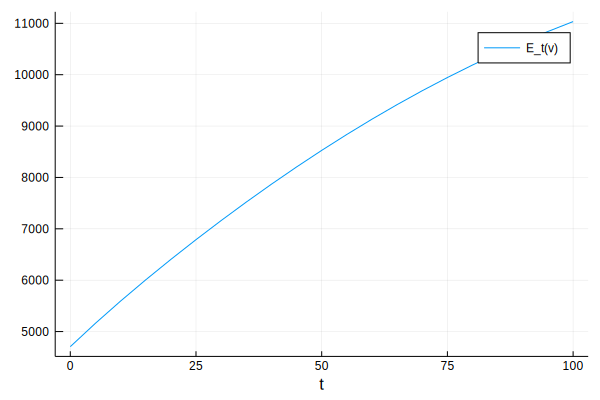

In [66]:
using OrdinaryDiffEq, DiffEqOperators

function solve_transition_dynamics(p, t)
    @unpack N, M = p

    ψ_0 = [1.0; fill(0.0, N^M - 1)]
    O! = MatrixFreeOperator((dψ, ψ, p, t) -> Q_T_mul!(dψ, ψ, p), (p, 0.0), size=(N^M,N^M), opnorm=(p)->1.25)

    # define the corresponding ODE problem
    prob = ODEProblem(O!,ψ_0,(0.0,t[end]), p)
    return solve(prob, LinearExponential(krylov=:simple), tstops = t)
end
t = 0.0:5.0:100.0
p = default_params(N=10, M=6)
sol = solve_transition_dynamics(p, t)
v = solve_bellman(p)
plot(t, [dot(sol(tval), v) for tval in t], xlabel = "t", label = ["E_t(v)"])

The above plot (1) calculates the full dynamics of the Markov chain from the $ n_m = 1 $ for all $ m $ initial condition; (2) solves the dynamics of a system of one-million ODEs; and; (3) uses the calculation of the Bellman equation to find the expected valuation during that transition.  The entire process takes less than 30 seconds.